In [1]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Data Preprocessing
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import os
import numpy as np
from scipy.signal import resample

def load_data(folder_path):
    data_dict = {}
    labels = None

    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.npy'):
            file_path = os.path.join(folder_path, file)
            data = np.load(file_path)

            if 'label' in file.lower():
                labels = data.squeeze()
            elif data.ndim == 3:
                sensor_name = file.replace('.npy', '')
                data_dict[sensor_name] = data

    return data_dict, labels

def normalize_data(data_dict):
    normalized_data = {}
    for sensor, data in data_dict.items():
        mean = data.mean(axis=(0, 1), keepdims=True)
        std = data.std(axis=(0, 1), keepdims=True) + 1e-8
        normalized_data[sensor] = (data - mean) / std
    return normalized_data

In [2]:
!pip install tsfresh

In [3]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Feature-Extraction
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from tsfresh.feature_extraction.feature_calculators import mean_abs_change, cid_ce

def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

def extract_features_from_sample(sample):
    """
    sample: ndarray with shape (T, C)
    Returns: feature vector (flattened over all channels)
    """

    T, C = sample.shape
    features = []

    for c in range(C):
        sig = sample[:, c]

        iqr = np.percentile(sig, 75) - np.percentile(sig, 25)
        pos_peaks, _ = find_peaks(sig)
        neg_peaks, _ = find_peaks(-sig)
        num_pos_peaks = len(pos_peaks)
        num_neg_peaks = len(neg_peaks)
        mac = mean_abs_change(sig)
        cid = cid_ce(sig, normalize=True)


        features.extend([
            np.max(sig),               # Maximum
            np.min(sig),               # Minimum
            np.mean(sig),              # Average
            np.std(sig),               # Standard-deviation
            zero_crossing_rate(sig),   # Zero Crossing Rate
            np.percentile(sig, 20),    # Percentil 20
            np.percentile(sig, 50),    # Median (Percentil 50)
            np.percentile(sig, 80),    # Percentil 80
            iqr,                       # Interquartile (IQR)
            np.var(sig),               # Varianz
            num_pos_peaks,             # Anzahl positiver Peaks
            num_neg_peaks,             # Anzahl negativer Peaks
            mac,                       # Mean Absolute Change
            cid                        # Complexity invariant distance
        ])
    return np.array(features)

def extract_features_from_sample_combined(sample_dict):
    """
    sample_dict: dict of sensor_name -> ndarray (T, C)
    Returns: combined feature vector (flattened over all channels and sensors)
    """
    features = []

    for sensor_name, sample in sample_dict.items():
        feats = extract_features_from_sample(sample)  # Extract features for each sensor sample
        features.extend(feats)  # Combine features from all sensors into a single vector
    return np.array(features)

def extract_features(data_dict):
    """
    data_dict: dict of sensor_name -> ndarray (N, T, C)
    Returns: X -> ndarray (N, F) - Features
    """
    feature_list = []
    n_samples = None

    for sensor_name, sensor_data in data_dict.items():
        if n_samples is None:
            n_samples = sensor_data.shape[0]
        elif n_samples != sensor_data.shape[0]:
            raise ValueError(f"Inkonsistente Anzahl an Samples im Sensor '{sensor_name}'")

    # Extract features for each sample by combining all sensors
    for i in range(n_samples):
        sample_dict = {sensor_name: data[i] for sensor_name, data in data_dict.items()}
        feats = extract_features_from_sample_combined(sample_dict)
        feature_list.append(feats)

    # Stack all features
    X = np.vstack(feature_list)
    return X

In [4]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
SUPERVISOR ADJUSTMENT NEEDED; SEE COMMENTS
Main: Load Data, extract Features, train Classifier
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

# === Set the path to the training and test folders; PLEASE ADJUST it to run the code locally on your machine. ===
training_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/training"
testing_folder = "/content/drive/MyDrive/SS25/MDS4AT/02_ActivityMonitoring/testing/"

# === Load Trainings- und Testdata ===
training_data_dict, training_labels = load_data(training_folder)
testing_data_dict, testing_labels = load_data(testing_folder)

# === Normalize Trainings- und Testdata ===
normalized_training_data = normalize_data(training_data_dict)
normalized_testing_data = normalize_data(testing_data_dict)

# === Feature-Extraktion ===
X_train = extract_features(normalized_training_data)
X_test = extract_features(normalized_testing_data)

# === Split Training / Validation ===
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, training_labels, test_size=0.2, random_state=42)

# === Classification ===
clf = XGBClassifier(n_estimators=100, random_state=42)

# === Train model on Trainingsdata ===
clf.fit(X_train_split, y_train_split)

# === Validation ===
y_val_pred = clf.predict(X_val_split)

# === Test ===
y_test_pred = clf.predict(X_test)

Mounted at /content/drive


Validation Accuracy: 0.700218818380744
Test Accuracy: 0.6048951048951049
Validation Average F1-Score (Macro): 0.6784537234532584
Test Average F1-Score (Macro): 0.5966944468235895
F1-Score for each class:
 [0.84444444 0.86486486 0.56097561 0.66666667 0.41071429 0.53932584
 0.62337662 0.33333333 0.14       0.34482759 0.78846154 0.47887324
 0.92307692 0.68085106 0.83950617 0.82105263 0.7826087  0.875
 0.54368932 0.42622951 0.44705882 0.33802817 0.71052632 0.5
 0.02631579 0.51724138 0.44736842 0.50746269 0.65853659 0.48
 0.60194175 0.57446809 0.75294118 0.60465116 0.37681159 0.36144578
 0.71232877 0.51351351 0.76744186 0.80898876 0.79545455 0.80898876
 0.55696203 0.54237288 0.91954023 0.31111111 0.49019608 0.48717949
 0.60869565 0.66666667 0.81481481 0.72093023 0.4        0.84210526
 0.65822785]


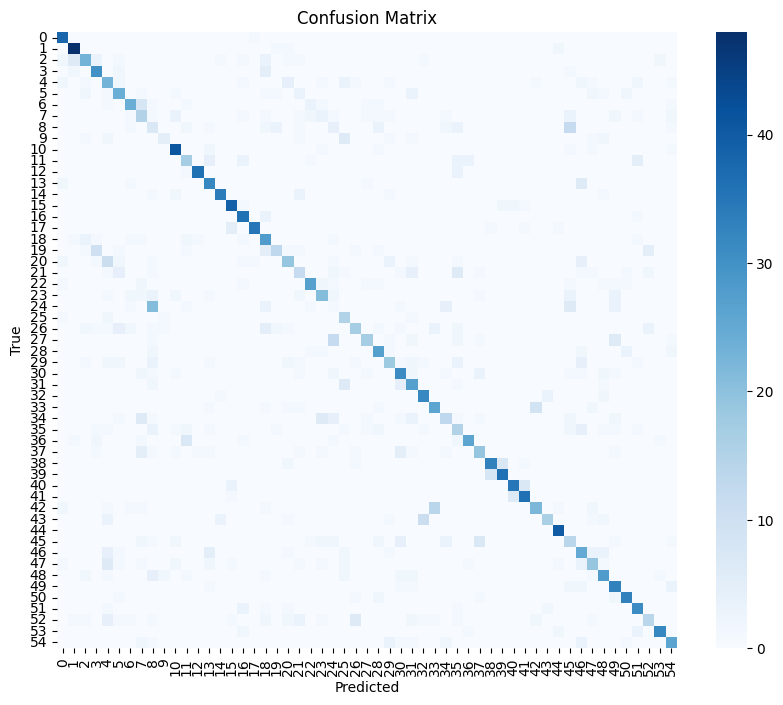

In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Evaluation
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

from sklearn.metrics import classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# === Accuracy ===
print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print("Test Accuracy:", accuracy_score(testing_labels, y_test_pred))

# === Average F1 Score (Macro) ===
f1_macro_val = f1_score(y_val_split, y_val_pred, average='macro')
print("Validation Average F1-Score (Macro):", f1_macro_val)
f1_macro_test = f1_score(testing_labels, y_test_pred, average='macro')
print("Test Average F1-Score (Macro):", f1_macro_test)

# === F1 Score for each class ===
print("F1-Score for each class:\n", f1_score(testing_labels, y_test_pred, average=None))

# === Confusion Matrix ===
cm = confusion_matrix(testing_labels, y_test_pred)

# === Set classes (0 to 54) ===
class_names = [str(i) for i in range(55)]

# === Heatmap Confusion Matrix ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=True)

# === Axis labels and title ===
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()